<h1>Real Time Audio Klassifizierung</h1>

Hier wollen wir ein Model erstellen, dass Sound klassifizieren soll. Dan soll das Model in Echtzeit Klassifizierungen durchführen.

Als Startpunkt orientieren wir uns an dem Notebook TF_Audio.

Als zusätzliche Aufgabe sollen die betroffenen stellen der Sounds markiert werden.

Um den Anfang zu machen, wollen wir als Ziel ein Model trainieren, dass Wörter erkennen soll.:
- Ein ASR Model (Automatic-speech-recognition)

Als Dataset nutzen wir:
> Speech Commands dataset (Warden, 2018) <br>
> https://www.tensorflow.org/datasets/catalog/speech_commands [Letzter Zugriff: 5.09.2024]

Dieses Dataset enthält folgende Wörter im Audioformat: "down", "go", "left", "no", "right", "stop", "up" und "yes" <br>

In [1]:
# Imports 
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

import IPython
from IPython import display

import sounddevice as sd
import librosa
from scipy.io import wavfile
import wave
from scipy import signal

from sklearn.metrics import classification_report


from scipy.io.wavfile import write
import wavio as wv

Lade Dataset herunter.

In [5]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [6]:
# Dataset enthält Ordner mit Audiodateien.
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print(f'Kommandos: {commands}')

Kommandos: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [7]:
# Erstelle Dataset # 
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,  # Padding 
    subset='both')
train_ds

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
label_names = train_ds.class_names
train_ds.class_names

['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

Alternativ können auch nur einige dieser Kommandos oder andere verwendet werden.

<h2>Audio File Analyse</h2>

Dafür eignen sich viele Libraries, generell.:
- scipy
- wave

In [9]:
random_command = np.random.randint(1, len(label_names)-1)
random_command = label_names[random_command]

listed_audio_files = os.listdir(DATASET_PATH+f"/{random_command}")

samplerate, data = wavfile.read(DATASET_PATH+f"/{random_command}/{listed_audio_files[6]}")
print(f"Kommando: {random_command}")
print(f"number of channels = {data.shape[0]}")

length = data.shape[0] / samplerate
print(f"Länge = {length}s")

Kommando: right
number of channels = 16000
Länge = 1.0s


<b>Samplerate</b>: Samples pro Sekunde (Hz)<br>
<b>Data</b>: Stellt die Amplitude der Schallwellen bei jedem Sample dar. Die Struktur ist abhängig von der Anzahl der Channels (mono, stereo) und der Bittiefe. <br>
Mono: 1D, Stereo: 2D, für rechts und links.

Die Bittiefe beschreibt die Range und Genauigkeit der Werte. Jedes Sample repräsentiert durch die Amplitude wie laut es ist. Bei einer Tiefe von 16-Bit sind also 2^16 Werte möglich.

In [10]:
samplerate

16000

In [11]:
data[:10]

array([-1, -2, -1,  1, -1,  1,  2,  2,  2,  2], dtype=int16)

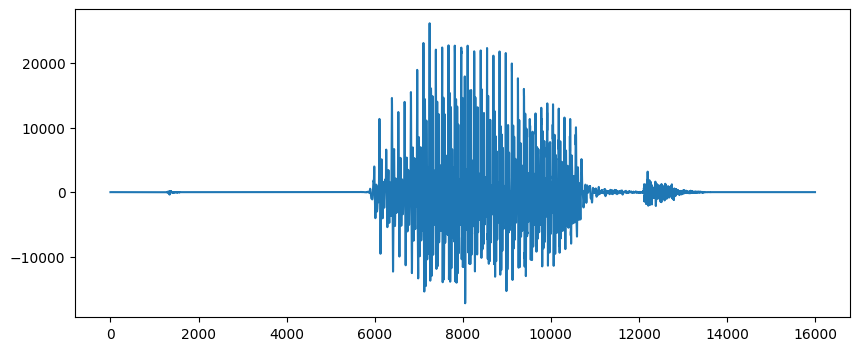

In [12]:
plt.figure(figsize=(10,4))
plt.plot(data)

In [13]:
# Mit Wave # 
wave_audiofile = wave.Wave_read(DATASET_PATH+f"/{random_command}/{listed_audio_files[6]}")

In [14]:
wave_audiofile.getnchannels()
# Auch:
# - max
# - frame_rate
# ...

1

In [15]:
wave_audiofile.getframerate()

16000

Die Channels beschreiben dabei mono oder stereo. Ein Audiosignal was in waveform vorliegt, kann in ein Spektrogramm umgeformt werden, was das Signal in x: Zeit und y: Frequenz aufteilt (siehe Plot), die Pixelwerte geben dabei Stärke der Sounds an, was man auch Dezibel nennt. Da ein Spektrogramm als 2D Bild vorliegt, können herkömmliche CNNs verwendet werden. Da Audio eine Sequenz darstellt, können RNNs und CNN-RNNs verwendet werden.

Genau das ist ein gutes Beispiel für die Verwendung von RNNs bei Bilddaten.

- Vergiss nicht zu normalisieren und zu Argumentieren

In [16]:
# Wandel in Spektrogramm um #
# In Tensorflow Style # 
def get_spectrogram(waveform):
    # Short-Time Fourier Transformation: Analysiere Frequenz 
    # - Teile Signal in Frames ein, wende auf Frame Fourier Transformation an.
    # - frame_length: nehme n-Samples für den Frame
    # - frame_step: Overlapping. Seichterer Übergang. 
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    # Ergebnis sind komplexe Zahlen => berechne Betrag der Zahlen.
    # - Phasenifnromationen werden verworfen und Amplitude behalten
    #   Reich oft für Analyse des Frequenzinhalts.
    spectrogram = tf.abs(spectrogram)  # 2D Repräsentation 
    # Füge eine Achse hinzu, da z. B. CNN ein 3D Tensor erwartet. 
    # - Statt RGB 3D Channel ist es hier ein Greyscale 1D Channel.
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [17]:
# Numpy # 
def get_numpy_spectrogram(samplerate, waveform):

    # Normalisiere, wähle Methode. 
    waveform_normalized = waveform / np.max(np.abs(waveform))
    
    frequenz, times, spectrogram = signal.stft(waveform_normalized, fs=samplerate, nperseg=255, noverlap=128)
    
    spectrogram = np.abs(spectrogram)
    spectrogram = spectrogram[..., np.newaxis]
    # Oder gebe auch frequencies und times zurück
    return spectrogram

In [18]:
def plot_spectrogram(spectrogram):
      if len(spectrogram.shape) > 2:
            assert len(spectrogram.shape) == 3
      spectrogram = np.squeeze(spectrogram, axis=-1)
      # Transponiere: x: Zeit
      # Füge Eps. hinzu, dmait nicht log(0).
      log_spec = np.log(spectrogram.T + np.finfo(float).eps)
      height = log_spec.shape[0]
      width = log_spec.shape[1]
      X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
      Y = range(height)
      plt.figure(figsize=(15,4))
      plt.ylabel('Frequenz [Hz]')
      plt.xlabel('Zeit [s]')
      plt.pcolormesh(X, Y, log_spec)
      plt.colorbar(label='Stärke [dB]')

In [19]:
# Lade .wav Datei #
samplerate, waveform = wavfile.read(DATASET_PATH+f"/{random_command}/{listed_audio_files[6]}")
audio_spectrogram = get_numpy_spectrogram(samplerate, waveform)
audio_spectrogram

array([[[1.08814630e-05],
        [6.26773464e-06],
        [3.59775623e-06],
        ...,
        [8.34652681e-06],
        [1.31868023e-05],
        [5.31297382e-06]],

       [[1.74532021e-05],
        [4.86921282e-06],
        [8.92291665e-06],
        ...,
        [2.01861938e-05],
        [1.50538247e-05],
        [1.35457487e-05]],

       [[2.31681636e-05],
        [2.74612242e-05],
        [1.71766230e-05],
        ...,
        [1.85492961e-05],
        [3.69256444e-05],
        [1.89670886e-05]],

       ...,

       [[6.09716738e-07],
        [1.77648656e-07],
        [1.35833850e-06],
        ...,
        [1.10280762e-06],
        [1.54336711e-06],
        [6.25137621e-07]],

       [[6.03282907e-07],
        [2.93688434e-07],
        [1.48552269e-06],
        ...,
        [3.38132400e-07],
        [6.28604011e-07],
        [2.17281442e-07]],

       [[6.28471060e-07],
        [1.19699748e-07],
        [6.14515371e-07],
        ...,
        [4.61929431e-07],
        [1.1411

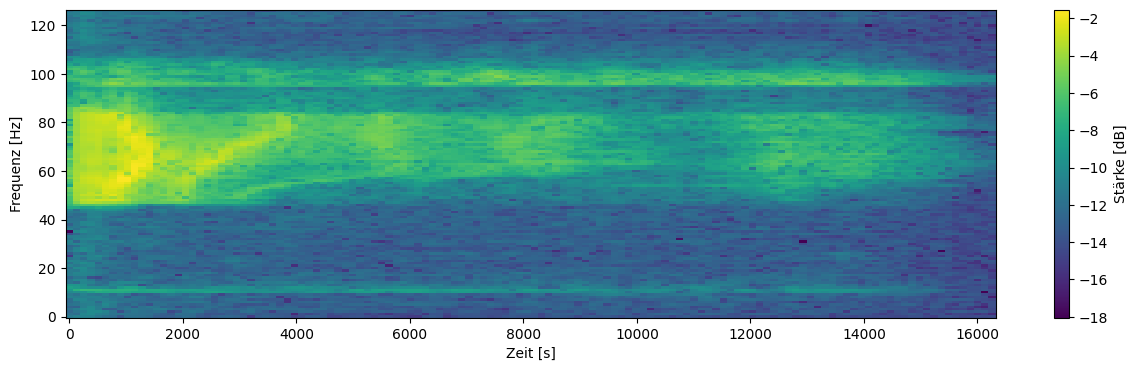

In [20]:
plot_spectrogram(audio_spectrogram)

Mit TensorFlow würde man das so angehen:

In [21]:
# Entferne eine Achse, da Single-Channel # 
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds   = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [22]:
example_audio_signals = []
for example_audio, example_labels in train_ds.take(1):  
      example_audio_signals.append(example_audio)

In [23]:
tf_audio_spectrogram = get_spectrogram(example_audio_signals[0])[0]

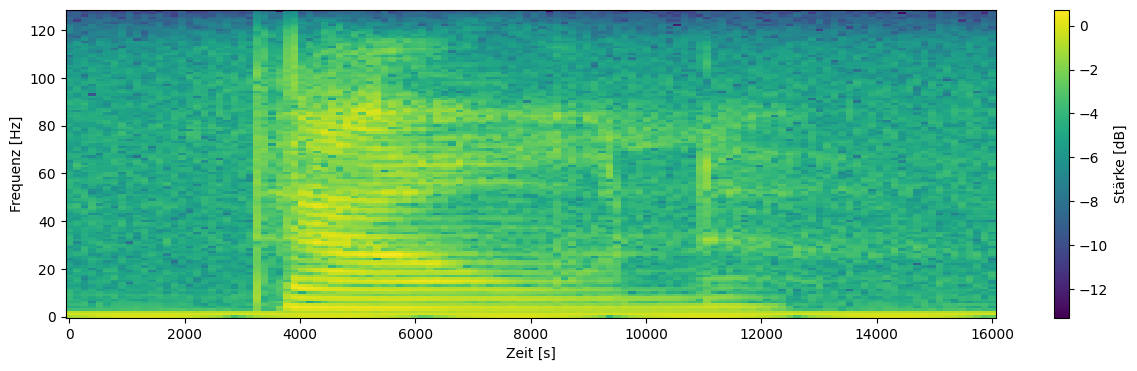

In [24]:
plot_spectrogram(tf_audio_spectrogram)

In [25]:
tf_audio_spectrogram

<tf.Tensor: shape=(124, 129, 1), dtype=float32, numpy=
array([[[3.3032542e-01],
        [8.6649549e-01],
        [4.3549162e-01],
        ...,
        [9.5320996e-05],
        [1.0116023e-04],
        [4.6804547e-05]],

       [[3.8123477e-01],
        [8.4070766e-01],
        [4.2384359e-01],
        ...,
        [1.1630582e-04],
        [1.5406140e-04],
        [6.0647726e-05]],

       [[4.8545671e-01],
        [8.5349751e-01],
        [4.3315887e-01],
        ...,
        [2.5949392e-05],
        [6.0158145e-05],
        [2.3856759e-05]],

       ...,

       [[1.3450077e-01],
        [8.4713757e-01],
        [4.1132620e-01],
        ...,
        [5.0299474e-05],
        [6.2675834e-05],
        [6.6310167e-05]],

       [[6.6373229e-02],
        [8.4855998e-01],
        [4.1165495e-01],
        ...,
        [5.1328632e-05],
        [8.2641182e-06],
        [2.0094216e-05]],

       [[8.3473578e-02],
        [8.6038220e-01],
        [4.2065221e-01],
        ...,
        [1.3905462e

<h2>Model und Dataset</h2>

Jetzt bereiten wir das Dataset vor und erstellen das Model.

In [26]:
# Erstelle Test- und Validationset #
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds  = val_ds.shard(num_shards=2, index=1)

Dann die Daten in ein Spektrogramm umwandeln.

In [27]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
train_ds_spec = make_spec_ds(train_ds)
val_ds_spec   = make_spec_ds(val_ds)
test_ds_spec  = make_spec_ds(test_ds)

Dann erstellen wir das Model.

In [29]:
input_shape = tf_audio_spectrogram.get_shape()
num_classes = len(label_names)

norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(data=train_ds_spec.map(map_func=lambda spec, label: spec))

sound_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    # ---
    tf.keras.layers.Resizing(80, 90),
    # ---
    norm_layer,
    # ---
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
    # ---
    # Reshape für RNN
    # ---
    tf.keras.layers.Reshape((-1, 128)),
    tf.keras.layers.LSTM(64, return_sequences=False),
    #tf.keras.layers.LSTM(128, return_sequences=False),
    # --
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=num_classes, activation="softmax"), 
])

sound_model.compile(
    optimizer='adam',
    loss     = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics  = ["accuracy"]
)

tf_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/real_time_audio/sound_model", histogram_freq=1)

sound_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 80, 90, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 80, 90, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 78, 88, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 39, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 37, 42, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 72, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,763 (573.30 KB)

 Trainable params: 146,760 (573.28 KB)

 Non-trainable params: 3 (16.00 B)

In [131]:
history_base = sound_model.fit(train_ds_spec, validation_data=val_ds_spec, epochs=35, batch_size=32)#, callbacks= [tf_callback])

Epoch 1/35
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.1880 - loss: 1.9642 - val_accuracy: 0.3600 - val_loss: 1.5881
Epoch 2/35
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.3521 - loss: 1.5690 - val_accuracy: 0.3862 - val_loss: 1.4037
Epoch 3/35
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.3939 - loss: 1.4203 - val_accuracy: 0.4300 - val_loss: 1.3785
Epoch 4/35
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.4617 - loss: 1.2901 - val_accuracy: 0.5913 - val_loss: 1.0410
Epoch 5/35
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.5775 - loss: 1.0596 - val_accuracy: 0.6225 - val_loss: 1.0302
Epoch 6/35
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - accuracy: 0.6530 - loss: 0.9238 - val_accuracy: 0.7063 - val_loss: 0.7962
Epoch 7/35
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.7007 - loss: 0.8147 - val_accuracy: 0.7663 - val_loss: 0.6919
Epoch 8/35
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.7545 - loss: 0.6806 - 

In [132]:
sound_model.evaluate(test_ds_spec)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8580 - loss: 0.5427


[0.48121631145477295, 0.8687499761581421]

In [66]:
pred = sound_model.predict(test_ds_spec)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [67]:
pred_argmax =  [ np.argmax(i) for i in pred ]
pred_argmax = np.array(pred_argmax)

y_true = tf.concat(list(test_ds_spec.map(lambda s,lab: lab)), axis=0)

In [152]:
print(classification_report(pred_argmax, y_true))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84        73
           1       0.86      0.73      0.79       130
           2       0.91      0.84      0.88       114
           3       0.87      0.80      0.83       110
           4       0.95      0.94      0.95        86
           5       0.83      0.96      0.89        98
           6       0.93      0.86      0.90       100
           7       0.87      0.93      0.90        89

    accuracy                           0.87       800
   macro avg       0.87      0.88      0.87       800
weighted avg       0.87      0.87      0.87       800



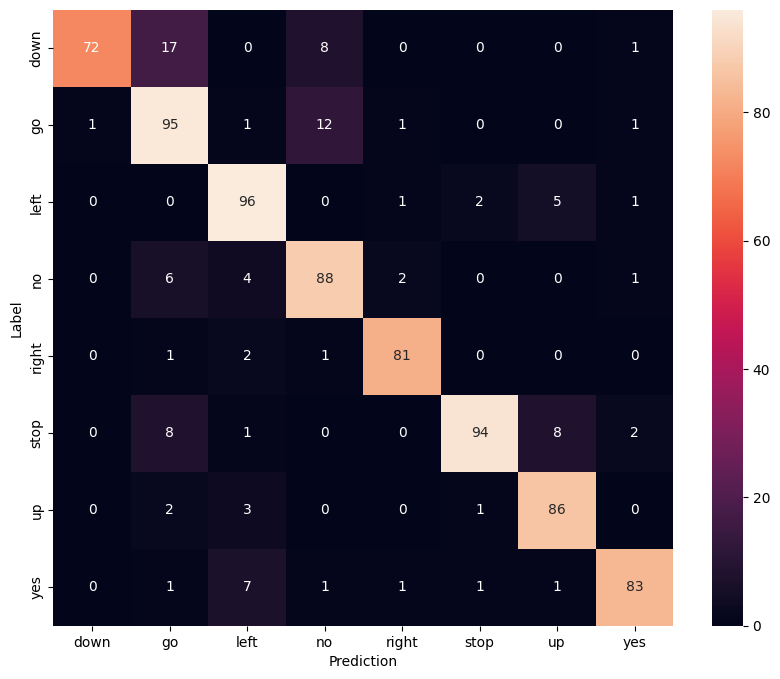

In [154]:
confusion_mtx = tf.math.confusion_matrix(y_true, pred_argmax)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Dann soll das Model gespeichert werden.

In [158]:
# Speichere
sound_model.save_weights("./data/data/saved_models/sound_model.weights.h5")
# Lade
#sound_model.load_weights("./data/data/saved_models/sound_model.weights.h5")

<h2>Predictions</h2>

Lade Model

In [30]:
sound_model.load_weights("./data/data/saved_models/sound_model.weights.h5")

C:\Users\Alexander\anaconda3\envs\tensorflow\lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [33]:
sound_model.evaluate(test_ds_spec, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8580 - loss: 0.5427


{'accuracy': 0.8687499761581421, 'loss': 0.48121631145477295}

In [119]:
# Frequenz: 
freq = 16000
# Aufnahmezeit: 
record_time = 3

# Nehme mit Mikrofon auf
def record_audio():
    print("Starte Aufnahme")
    audio = sd.rec(int(freq * record_time), samplerate=freq, channels=1)
    sd.wait()  
    print("Aufnahme beendet")
    return np.squeeze(audio)

In [177]:
mic_audio = record_audio()

Starte Aufnahme
Aufnahme beendet


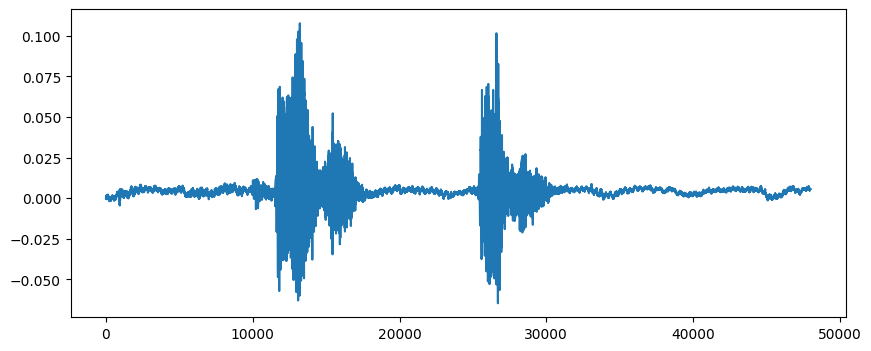

In [178]:
plt.figure(figsize=(10, 4))
plt.plot(mic_audio)

In [135]:
dict_labels = {0:"down", 1:"go",2:"left",3:"no",4:"right",5:"stop",6:"up",7:"yes",}

In [150]:
# Gebe Zahl oder Label aus. 
# *Gut für Audiosignale die auch ~ 1s lang sind. 
def make_prediction(model, data, freq:int=16000, retlabel:bool=False, retall:bool=False):
    spektogramm = get_numpy_spectrogram(freq, data)
    
    spektogramm = np.expand_dims(spektogramm, axis=0)  
    spektogramm = np.expand_dims(spektogramm, axis=-1) 
    
    prediction = model.predict(spektogramm)
    predicted_class = np.argmax(prediction)
    if retlabel:
        return dict_labels[predicted_class]
    elif retall:
        pred_dict = {}
        for i, data in enumerate(prediction[0]):
            pred_dict[dict_labels[i]] = data
        return pred_dict
    else:
        return predicted_class

In [151]:
res = make_prediction(sound_model, mic_audio, retlabel=False,  retall=True)
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


{'down': 0.1074539,
 'go': 0.18677981,
 'left': 0.06034174,
 'no': 0.11814299,
 'right': 0.14962973,
 'stop': 0.06492305,
 'up': 0.14052695,
 'yes': 0.17220178}

In [147]:
IPython.display.Audio(DATASET_PATH+f"/{random_command}/{listed_audio_files[6]}")

In [162]:
samplerate, waveform = wavfile.read(DATASET_PATH+f"/{random_command}/{listed_audio_files[6]}")

In [163]:
res = make_prediction(sound_model, waveform, retlabel=False,  retall=True)
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


{'down': 0.11943167,
 'go': 0.18394285,
 'left': 0.05363595,
 'no': 0.10164255,
 'right': 0.15303954,
 'stop': 0.074807376,
 'up': 0.14695638,
 'yes': 0.16654366}

<h3>Split Audio und Padding</h3>

Bei längeren Audiosignalen die z. B. 10-Sekunden klang sind, müssen diese in Schnipsel zerlegt werden.

<b>*</b>Es gibt verschiedene Ansätze ein längeres Audiosignal für eine Predictions zu nutzen, Streaming kann wäre auch möglich. Besonders wichtig wird es bei Real Time Predictions.

<u>Bevor</u> wir eigene Aufnahmen nutzen, testen wir den Aufbau mit den vorhanden Audiosignalen. Um die Aufnahmen zu verlängern, nutzen wir eine Paddingmethode um z. B. Nullen einzufügen. Damit können dann die Waveformdataien auf 10 Sekunden gestreckt werden.

Hier nutzen wir den Ansatz Slidning-Window.

In [182]:
# Teile Audio in Frames ein. #
# - Slidning-Window
def split_audio_in_frames(audio, frame_length, frame_step, sample_rate:int=16000):
    frame_samples      = int(frame_length * sample_rate)
    frame_step_samples = int(frame_step   * sample_rate)

    # frame_length: Wie lange ein Frame sein soll. Hier: 1s, wegen Trainingsdaten.
    # frame_step:   Schrittweite des Frames

    # Nutze Slinding Window mit Overlap #
    audio_frames = []
    for i in range(0, len(audio) - frame_samples + 1, frame_step_samples):
        frame = audio[i:i+frame_samples]  # Fesnter 
        # Diese Frames dann für Prediction nutzen. #
        audio_frames.append(frame)
    return np.array(audio_frames)

Anders als wie oben, nutzen wir alle n-Frames für doe Prediction. <br>
<b>*</b>Wenn ein Signal keine bedeutsamen Inhalte hat, geben wir nichts aus oder sagen, dass es an dieser Stelle nichts gibt. Das können wir machen, indem wir einen threshold angeben, ab wann ein Signal als Klasse gilt, z. B. ein Wert höher als 0.6 ist eine Klassifizierung, alles darunter ist keine Klasse. Das gilt auch für andere Probleme und Anwendungen.

In [180]:
def predict_on_audioFrames(model, frames, threshold:int=0.11):
    # Sammmel Preditions oder gebe nur eine Antwort aus.
    predictions = []  # Pro Frame
    # Hier kann auch z. B. nur ausgegeben werden, ob ein bestimmtes Geräusch entdeckt wurde, mit 0 der 1.
    for frame in frames:
        spektogramm = get_numpy_spectrogram(16000, frame) 
        spektogramm = np.expand_dims(spektogramm, axis=0)  
        spektogramm = np.expand_dims(spektogramm, axis=-1)
        prediction  = model.predict(spektogramm)

        if True in (prediction >= threshold):  # Klasse endeckt. 
            class_index = np.argmax(prediction)
            print(prediction)
            predictions.append(class_index)
        else:
            predictions.append(-1)  # Keine Klasse -> -1, oder was ähnliches...  
    return predictions

Jetzt wählen wir eine einige Dateien aus und nutzen Padding. Danach werden diese für die Predictions genutzt, am Ende sehen wir wie gut der Slidning-Window Ansatz für längere Aufnahmen funktioniert.

In [181]:
split_record = split_audio_in_frames(mic_audio, 1, 0.5)

result = predict_on_audioFrames(sound_model, split_record)
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0.11035163 0.18526126 0.05834627 0.11147491 0.14695601 0.06660338
  0.1411808  0.17982563]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[0.13126236 0.3236191  0.02784402 0.08058561 0.07792735 0.10218142
  0.08799136 0.16858871]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[0.10568199 0.24011753 0.04896165 0.10058753 0.10661048 0.08332848
  0.10801474 0.20669764]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.12507999 0.24788888 0.04415034 0.10797361 0.11240298 0.08550564
  0.11509941 0.16189921]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.11289143 0.18332507 0.05767972 0.11077207 0.15582544 0.06824428
  0.14830494 0.16295704]]


[1, 1, 1, 1, 1]

In [116]:
result

<h1>Data Argumentation für Audio Dateien und Sonstiges</h1>